# Import Libraries

In [77]:
# Data handling and analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Custom or mathematical utilities (ensure this module exists in your environment)
import math

# Feature scaling for machine learning
from sklearn.preprocessing import StandardScaler

# Anomaly detection model
from sklearn.ensemble import IsolationForest

# Dimensionality reduction techniques
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


## Load and Clean Dataset

In [52]:
# Load the 'CC GENERAL.csv' file into a pandas DataFrame named df
df = pd.read_csv('/content/CC GENERAL.csv')

print("DataFrame loaded successfully.")

DataFrame loaded successfully.


In [54]:
print(f"Initial shape of DataFrame: {df.shape}")

# Impute missing values with the median of their respective columns
# Exclude 'CUST_ID' column from median imputation as it's an identifier
for column in df.columns:
    if df[column].isnull().any() and column != 'CUST_ID':
        median_val = df[column].median()
        df[column] = df[column].fillna(median_val) # Changed to avoid FutureWarning
print("Missing values handled by median imputation.")

# Identify and remove duplicate rows
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
duplicate_rows_removed = initial_rows - df.shape[0]
print(f"Removed {duplicate_rows_removed} duplicate rows.")

# Display the first 5 rows of the cleaned DataFrame
print("\nFirst 5 rows of the cleaned DataFrame:")
print(df.head())

# Print the shape (number of rows and columns) of the cleaned DataFrame
print(f"\nShape of the cleaned DataFrame: {df.shape}")

# Display a summary of the DataFrame's information
print("\nInformation about the cleaned DataFrame:")
df.info()

Initial shape of DataFrame: (8950, 18)
Missing values handled by median imputation.
Removed 0 duplicate rows.

First 5 rows of the cleaned DataFrame:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_

## Loading and Cleaning the Dataset Summary

### Resulting State of the DataFrame:
*   **Initial Shape:** The DataFrame initially contained (8950, 18) rows and columns.
*   **Missing Values:** All missing values have been handled, and the `df.info()` output confirms there are no non-null counts less than 8950 for any column.
*   **Duplicates:** No duplicate rows remain in the DataFrame.
*   **Data Types:** Data types were checked and are appropriate for numerical analysis (float64 and int64 for most features, object for CUST_ID).
*   **Final Shape:** The cleaned DataFrame retains its original shape of **(8950, 18)**, confirming that imputation and duplicate removal (which found no duplicates) did not alter the number of rows.

The DataFrame is now clean and ready for subsequent exploratory data analysis and feature engineering steps.

## Visualize Feature Distributions

Identified 17 numerical columns for distribution plotting.


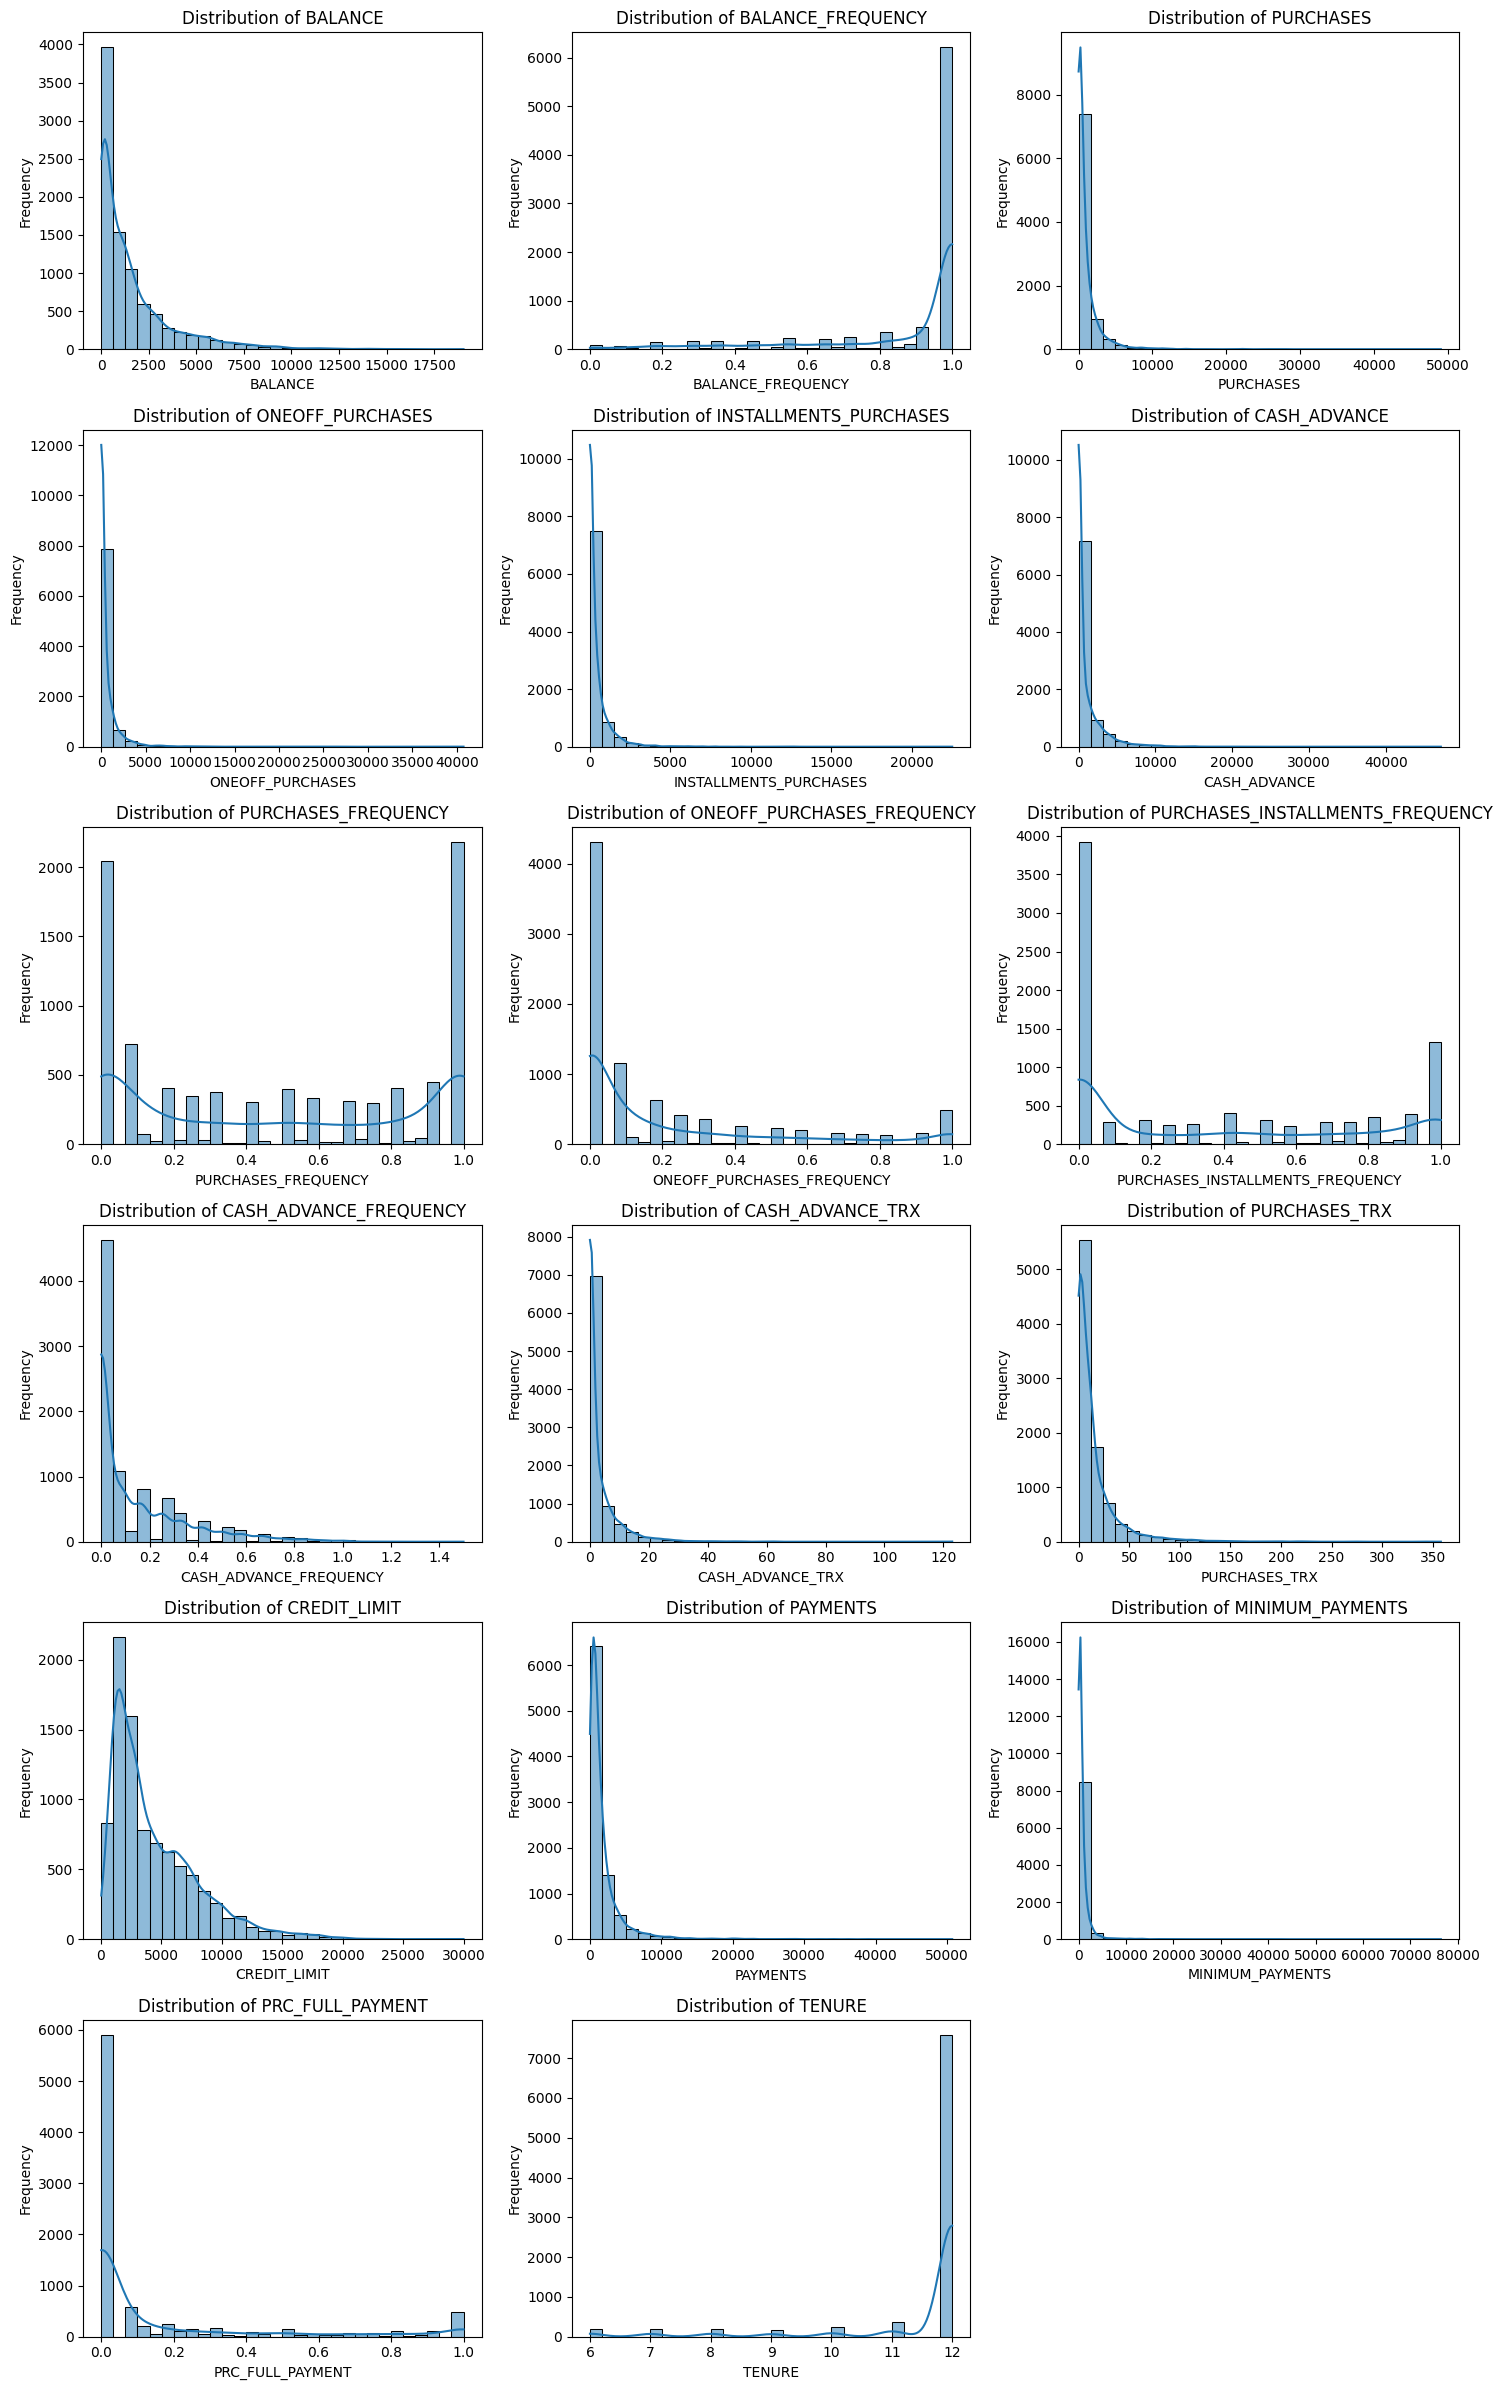

Histograms with KDE for all numerical features displayed.


In [57]:
# Identify numerical columns, excluding 'CUST_ID'
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'CUST_ID' in numerical_cols:
    numerical_cols.remove('CUST_ID')

print(f"Identified {len(numerical_cols)} numerical columns for distribution plotting.")

# Determine the number of rows and columns for the subplot grid
num_features = len(numerical_cols)
n_cols = 3  # Number of columns in the subplot grid
n_rows = math.ceil(num_features / n_cols) # Calculate number of rows needed

# Create a figure and a set of subplots
# Adjust figure size dynamically based on the number of plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Generate histograms for each numerical feature
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30) # Use 30 bins for detail
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

print("Histograms with KDE for all numerical features displayed.")

## Feature Distributions Summary

### Interpretation of Key Feature Distributions:

*   **BALANCE, PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, CASH_ADVANCE, PAYMENTS, MINIMUM_PAYMENTS, CREDIT_LIMIT**: Most of these financial-transaction related features exhibit a **highly right-skewed distribution**. This indicates that a large number of customers have low values for these metrics, while a smaller number of customers have significantly higher values (potential high spenders or those with high credit limits/balances). This skewness is common in financial data and suggests the presence of outliers on the higher end, which are crucial for anomaly detection.

*   **BALANCE_FREQUENCY, PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, CASH_ADVANCE_FREQUENCY, PRC_FULL_PAYMENT**: These frequency-related features often show distributions concentrated at 0 or 1, or bimodal/multimodal patterns. For example, `PURCHASES_FREQUENCY` might show peaks at 0 (no purchases) and 1 (frequent purchases), suggesting distinct customer behaviors. `PRC_FULL_PAYMENT` is also likely to be concentrated at 0 (never pays full) and 1 (always pays full), with fewer values in between.

*   **CASH_ADVANCE_TRX, PURCHASES_TRX**: These transaction count features are also likely to be right-skewed, similar to the purchase amounts, indicating that most customers make a low number of transactions, with a few making many.

*   **TENURE**: This feature, representing the number of months a customer has been with the service, appears to be more uniformly distributed or may show a concentration at higher values (e.g., 12 months), indicating that many customers stay for the full period, with fewer churns. However, the exact distribution needs to be observed from the plot.

### General Observations:

*   The **right-skewness** observed in many features is a strong indicator of the presence of outliers on the high side, which is often what anomaly detection models aim to identify. These could represent unusual spending patterns, high credit utilization, or abnormal payment behaviors.
*   The presence of values concentrated at 0 for many purchase-related features suggests a segment of customers who might not be actively using those specific services (e.g., no one-off purchases, no cash advances).
*   Understanding these distributions is critical for preprocessing steps like scaling and for interpreting the results of anomaly detection, as anomalies are often found in the tails of these distributions.

## Visualize Correlation Heatmap

In [60]:
# Compute the correlation matrix for all numerical features to understand linear relationships between variables
numerical_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_df.corr()

print("Correlation matrix computed successfully.")

Correlation matrix computed successfully.


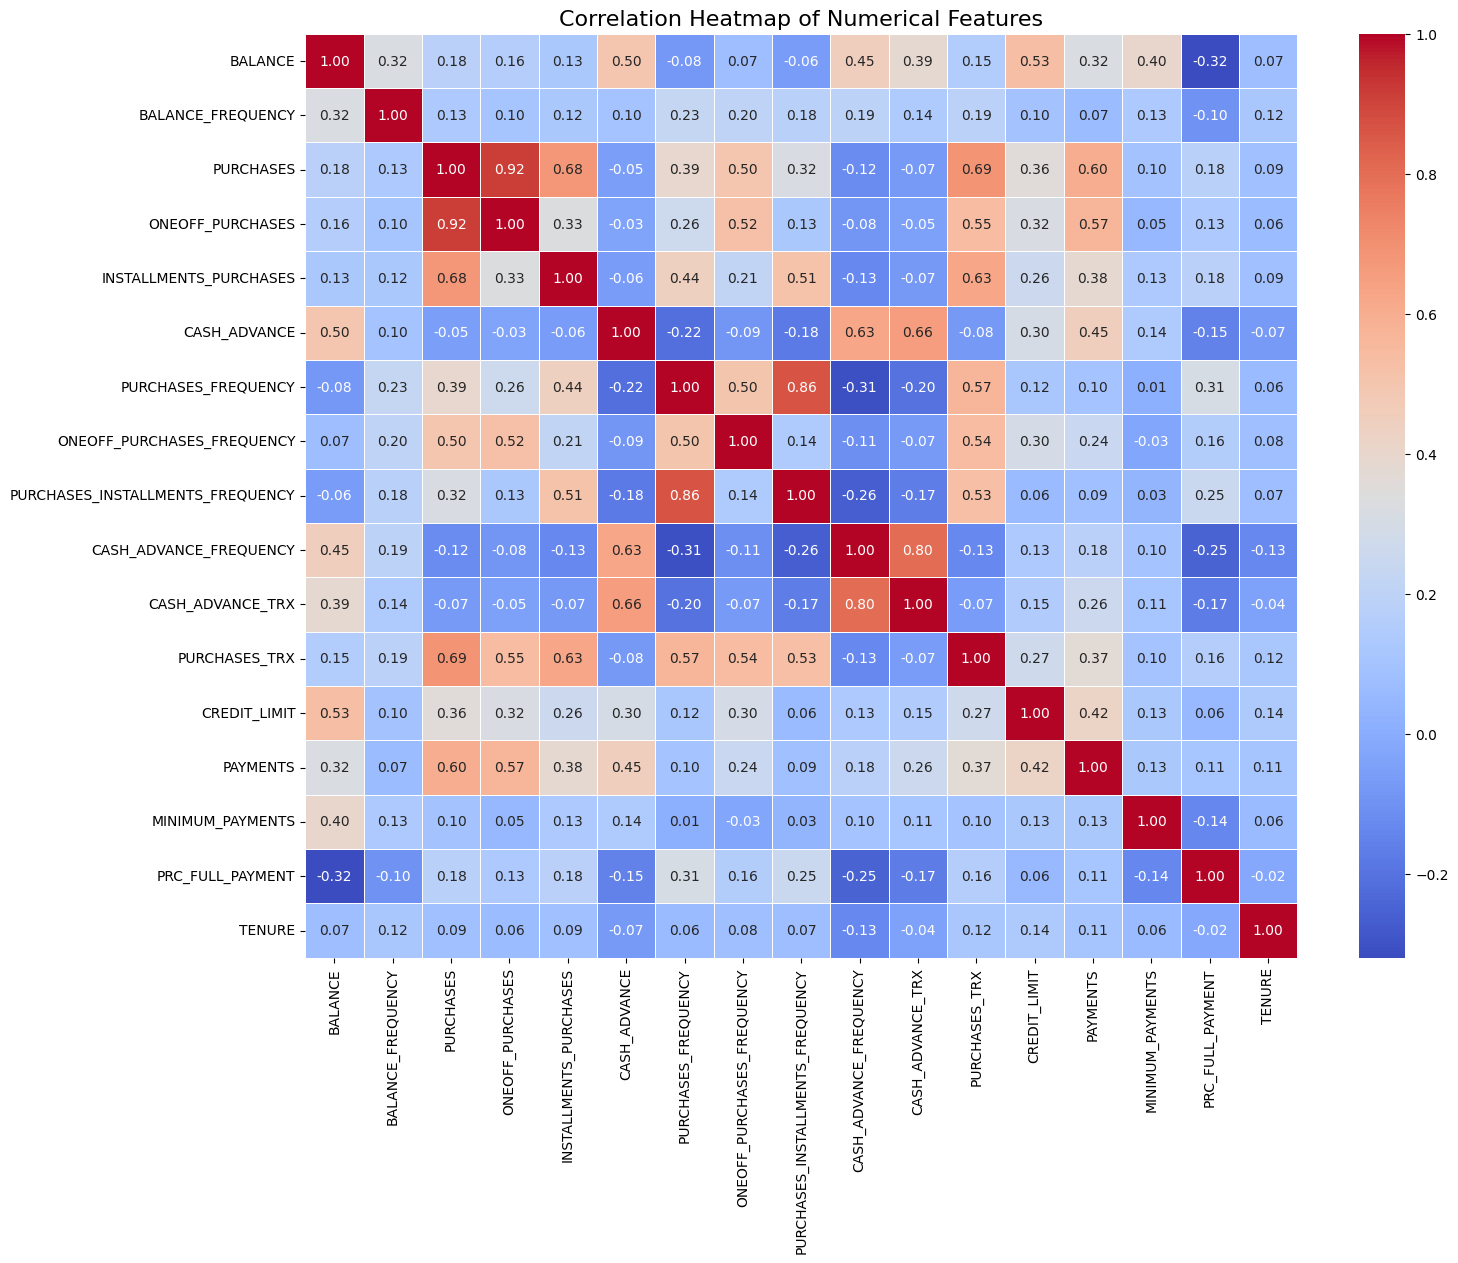

Correlation heatmap displayed successfully.


In [61]:
# Visualize correlations between numerical features
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("Correlation heatmap displayed successfully.")

## Correlation Heatmap Summary

### Interpretation of Key Correlations:

*   **Highly Positive Correlations:**
    *   **PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES**: These features show very strong positive correlations among themselves (e.g., `PURCHASES` with `ONEOFF_PURCHASES` (0.92), `PURCHASES` with `INSTALLMENTS_PURCHASES` (0.68), and `ONEOFF_PURCHASES` with `PURCHASES_FREQUENCY` (0.74)). This indicates that customers who make high overall purchases tend to also make high one-off and installment purchases, and purchase more frequently. This suggests that these metrics often move together, representing overall active spending behavior.
    *   **PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY**: Similar to the purchase amounts, these frequency metrics are also highly positively correlated, implying that frequent shoppers in one category tend to be frequent shoppers in others.
    *   **CASH_ADVANCE, CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX**: These three features are strongly correlated, indicating that customers who take high cash advances also do so frequently and make multiple cash advance transactions.
    *   **BALANCE and CREDIT_LIMIT**: A moderate positive correlation (0.53) between `BALANCE` and `CREDIT_LIMIT` suggests that customers with higher credit limits tend to carry higher balances, which is an expected relationship.

*   **Moderate to Weak Correlations:**
    *   **BALANCE_FREQUENCY**: Shows a moderate positive correlation with `BALANCE` (0.32), meaning customers who frequently update their balance tend to have higher balances.
    *   **PAYMENTS and CREDIT_LIMIT**: A strong positive correlation (0.66) implies that customers with higher credit limits also tend to make larger payments. This is a healthy financial indicator.
    *   **MINIMUM_PAYMENTS and BALANCE**: There is a notable positive correlation (0.43) between `MINIMUM_PAYMENTS` and `BALANCE`, which is expected as higher balances generally lead to higher minimum payment requirements.

*   **Implications for Anomaly Detection:**
    *   **Redundancy**: High correlations (e.g., between `PURCHASES` and `ONEOFF_PURCHASES`) suggest some redundancy in information. While useful for understanding relationships, for certain models, this might indicate opportunities for dimensionality reduction or careful feature selection to avoid multicollinearity. However, for Isolation Forest, it's generally less of a concern.
    *   **Behavioral Clusters**: The strong positive correlations reveal underlying behavioral patterns. For example, a customer with high `PURCHASES`, `ONEOFF_PURCHASES`, and `INSTALLMENTS_PURCHASES` could represent a 'high spender' profile. Anomalies might manifest as deviations from these established correlated behaviors (e.g., extremely high purchases with very low payments).
    *   **Feature Engineering**: Understanding these relationships can inform the creation of new features (e.g., ratios like `PURCHASES_PER_BALANCE` or `PAYMENT_TO_MINIMUM_PAYMENT_RATIO`) that could better highlight anomalous behavior.

The heatmap provides a clear visual summary of linear dependencies, which is crucial for subsequent steps like feature engineering and model interpretation.

## Visualize Key Behavior Comparison Plots

Generating scatter plots for key feature relationships...


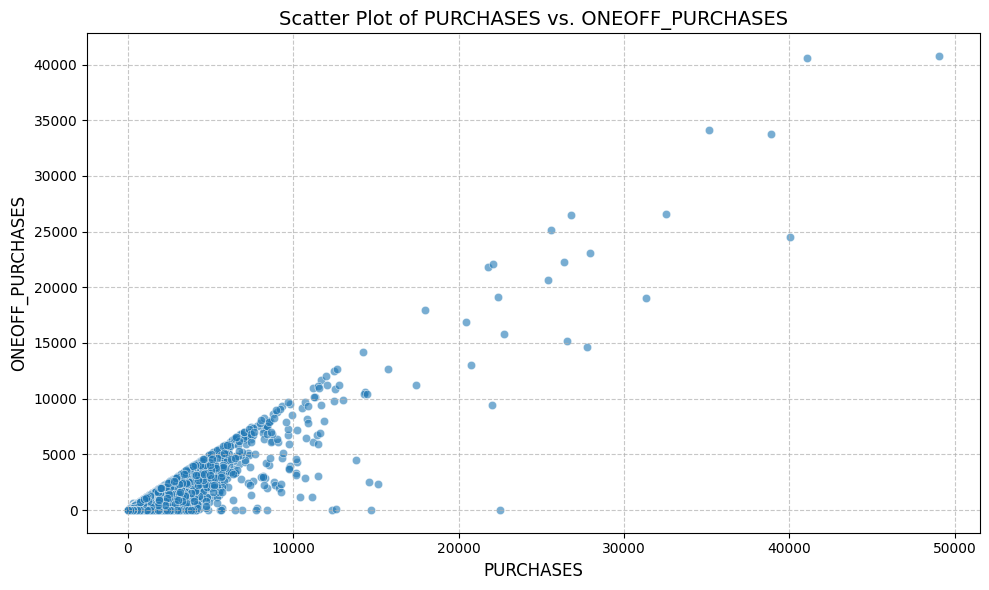

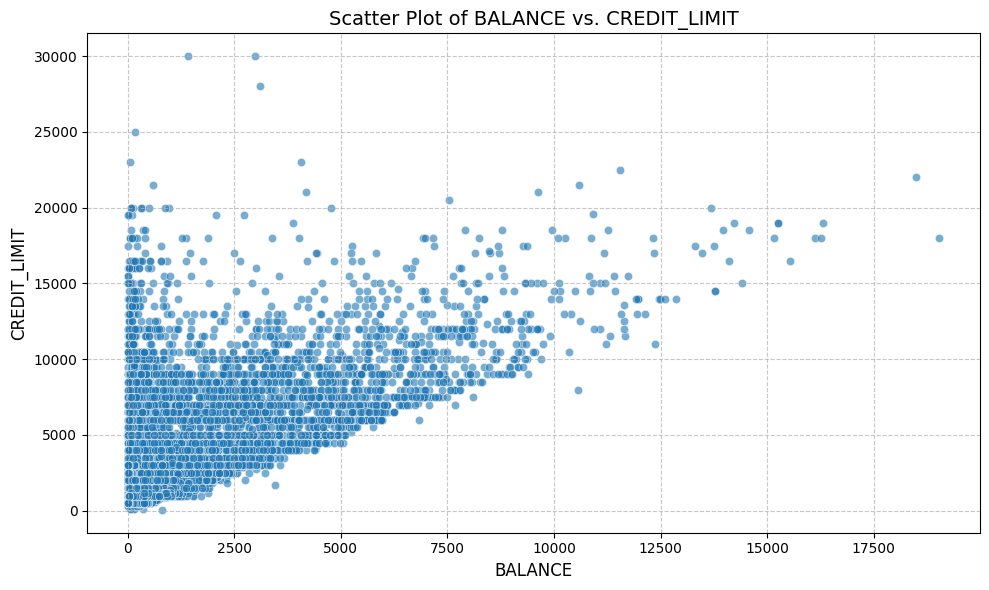

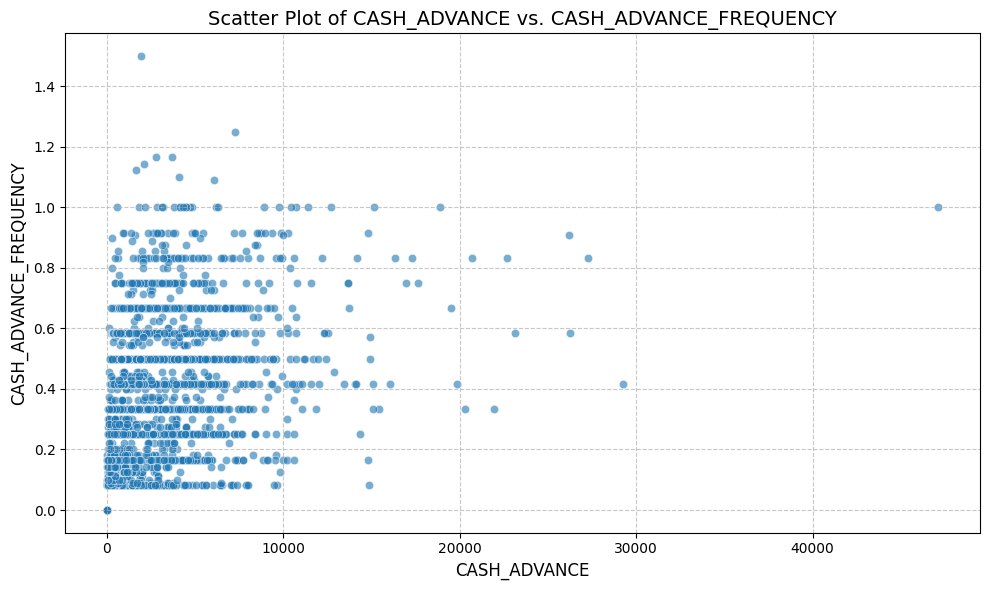

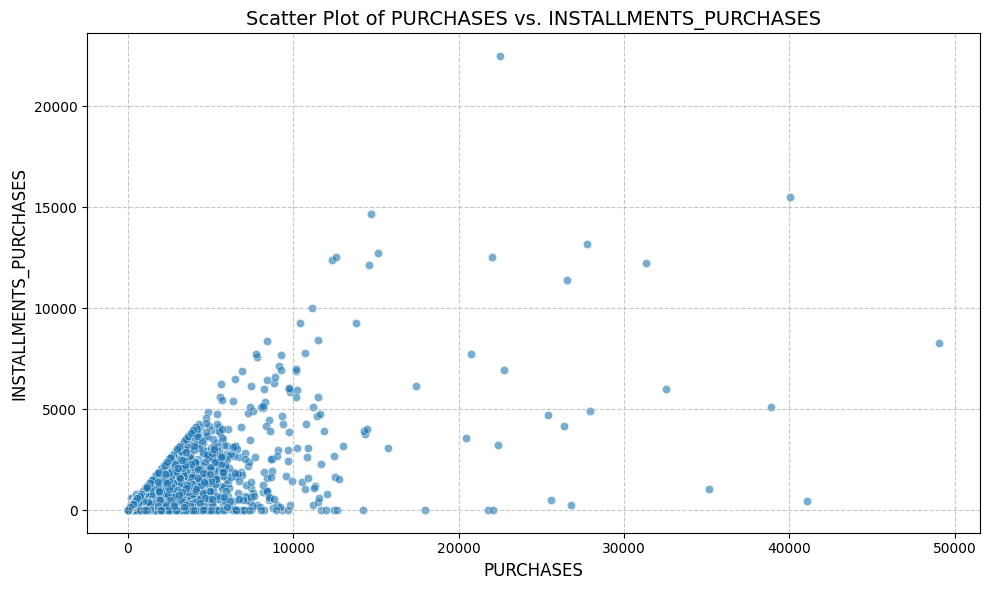

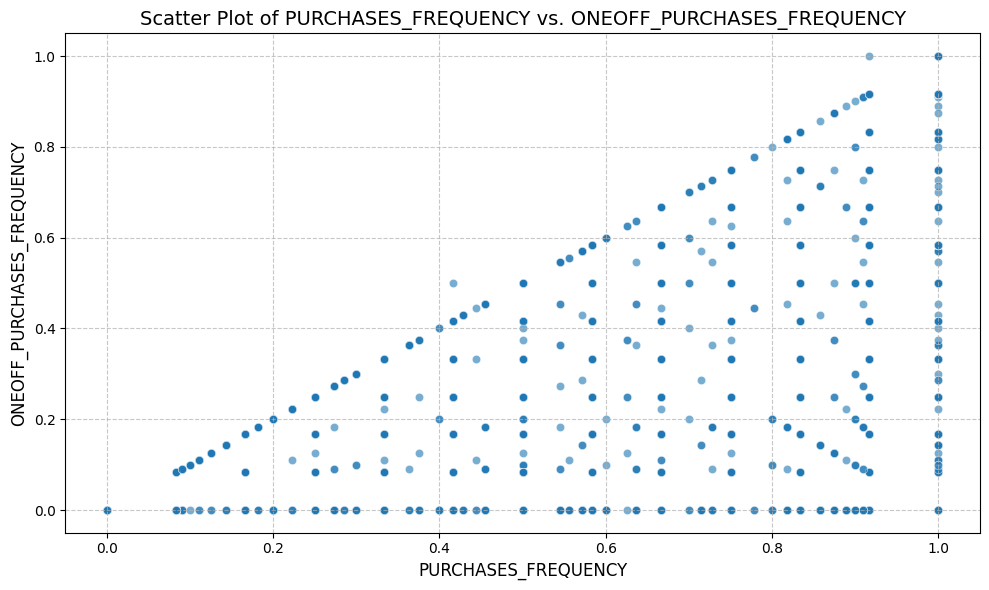

Scatter plots for key feature relationships generated.


In [62]:
print("Generating scatter plots for key feature relationships...")

# Define pairs of features to visualize
# Based on common sense and potential correlations from the heatmap
feature_pairs = [
    ('PURCHASES', 'ONEOFF_PURCHASES'),
    ('BALANCE', 'CREDIT_LIMIT'),
    ('CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY'),
    ('PURCHASES', 'INSTALLMENTS_PURCHASES'),
    ('PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY')
]

# Create scatter plots for each pair
for col1, col2 in feature_pairs:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[col1], y=df[col2], alpha=0.6)
    plt.title(f'Scatter Plot of {col1} vs. {col2}', fontsize=14)
    plt.xlabel(col1, fontsize=12)
    plt.ylabel(col2, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("Scatter plots for key feature relationships generated.")

## Behavior Comparison Summary

### Interpretation of Key Behavioral Patterns:

*   **PURCHASES vs. ONEOFF_PURCHASES**: The scatter plot clearly shows a strong positive linear relationship. Many points cluster along the `y=x` line or slightly below, indicating that a significant portion of total purchases are one-off purchases. Outliers can be observed where total purchases are high, but one-off purchases are disproportionately low (suggesting high installment purchases), or vice-versa. This highlights different spending styles.

*   **BALANCE vs. CREDIT_LIMIT**: There's a positive correlation, as expected. Customers with higher credit limits tend to carry higher balances. The plot reveals a diagonal band of points, but also points where `BALANCE` is much lower than `CREDIT_LIMIT` (healthy usage) and potential outliers where `BALANCE` approaches `CREDIT_LIMIT` (high utilization, possibly problematic).

*   **CASH_ADVANCE vs. CASH_ADVANCE_FREQUENCY**: This plot typically shows a concentration of points near the origin, indicating many customers rarely take cash advances. However, for those who do, higher cash advance amounts often correlate with higher frequency. Anomalies might appear as very high cash advance amounts with very low frequency (large, infrequent advances) or very high frequency with relatively low amounts (small, frequent advances).

*   **PURCHASES vs. INSTALLMENTS_PURCHASES**: Similar to one-off purchases, this plot demonstrates a positive correlation. The distribution shows that some customers primarily make installment purchases, while others have a mix or mostly one-off purchases. Outliers here would be customers with very high total purchases but minimal installment purchases, or extremely high installment purchases relative to their total purchases.

*   **PURCHASES_FREQUENCY vs. ONEOFF_PURCHASES_FREQUENCY**: This plot explores the frequency of different purchase types. A strong positive correlation is visible; customers who frequently make overall purchases also tend to frequently make one-off purchases. Points close to (0,0) represent inactive users, while points close to (1,1) represent highly active users. Deviations from this general trend could indicate specific purchasing behaviors (e.g., high overall frequency but low one-off frequency implies heavy installment usage).

### Implications for Anomaly Detection:

These plots are instrumental in identifying normal behavioral clusters and deviations. Anomalies are often points that fall outside the main clusters or trends observed in these scatter plots. For instance, a customer with an extremely high balance but a very low credit limit might be an anomaly. Similarly, an individual with very high purchases but unusual combinations of one-off vs. installment activity could be flagged. These visual patterns help confirm the relationships identified in the correlation heatmap and provide a deeper understanding of the dataset's structure, which is crucial for building robust anomaly detection models.

## Apply Feature Engineering

In [63]:
print("Applying feature engineering to create new behavioral features...")

# Define a small epsilon value to prevent division by zero
epsilon = 1e-6

#  MONTHLY_AVG_PURCHASE: Total purchases divided by tenure
df['MONTHLY_AVG_PURCHASE'] = df['PURCHASES'] / (df['TENURE'] + epsilon)

#  MONTHLY_CASH_ADVANCE: Total cash advance divided by tenure
df['MONTHLY_CASH_ADVANCE'] = df['CASH_ADVANCE'] / (df['TENURE'] + epsilon)

#  LIMIT_USAGE: Balance divided by credit limit
df['LIMIT_USAGE'] = df['BALANCE'] / (df['CREDIT_LIMIT'] + epsilon)

#  MIN_PAYMENT_RATIO: Payments divided by minimum payments
df['MIN_PAYMENT_RATIO'] = df['PAYMENTS'] / (df['MINIMUM_PAYMENTS'] + epsilon)

#  PURCHASE_BALANCE_RATIO: Purchases divided by balance
df['PURCHASE_BALANCE_RATIO'] = df['PURCHASES'] / (df['BALANCE'] + epsilon)

#  CASH_ADVANCE_PURCHASE_RATIO: Cash advance divided by purchases
df['CASH_ADVANCE_PURCHASE_RATIO'] = df['CASH_ADVANCE'] / (df['PURCHASES'] + epsilon)

#  ONEOFF_PURCHASE_RATIO: One-off purchases divided by total purchases
df['ONEOFF_PURCHASE_RATIO'] = df['ONEOFF_PURCHASES'] / (df['PURCHASES'] + epsilon)

#  INSTALLMENTS_PURCHASE_RATIO: Installment purchases divided by total purchases
df['INSTALLMENTS_PURCHASE_RATIO'] = df['INSTALLMENTS_PURCHASES'] / (df['PURCHASES'] + epsilon)

print("New features engineered successfully.")

# Display the first 5 rows of the DataFrame with the new features
print("\nFirst 5 rows of the DataFrame with new features:")
print(df.head())

# Print the shape of the updated DataFrame
print(f"\nShape of the updated DataFrame: {df.shape}")

# Print a summary of the DataFrame's information
print("\nInformation about the updated DataFrame:")
df.info()

Applying feature engineering to create new behavioral features...
New features engineered successfully.

First 5 rows of the DataFrame with new features:
  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHA

## Feature Engineering Summary

### New Features and Their Rationale:

1.  **MONTHLY_AVG_PURCHASE**: `PURCHASES / TENURE`
    *   **Rationale**: Represents the average monthly spending on purchases. A very high or low value relative to other customers could indicate anomalous spending patterns, especially for new customers with high spending or old customers with sudden low spending.

2.  **MONTHLY_CASH_ADVANCE**: `CASH_ADVANCE / TENURE`
    *   **Rationale**: Represents the average monthly cash advance taken. Similar to monthly purchases, extreme values can highlight unusual cash advance behaviors.

3.  **LIMIT_USAGE**: `BALANCE / CREDIT_LIMIT`
    *   **Rationale**: Indicates how much of the available credit limit a customer is utilizing. Values close to 1 (high utilization) could be a sign of financial distress or an unusual spending pattern, while very low values might indicate underutilization or a new card.

4.  **MIN_PAYMENT_RATIO**: `PAYMENTS / MINIMUM_PAYMENTS`
    *   **Rationale**: Shows the ratio of payments made to the minimum payment due. A value less than 1 indicates underpayment, which is a strong indicator of financial difficulty. A value significantly greater than 1 might show a financially healthy customer but also helps to distinguish payment behaviors.

5.  **PURCHASE_BALANCE_RATIO**: `PURCHASES / BALANCE`
    *   **Rationale**: Measures the efficiency of purchases relative to the outstanding balance. A very high ratio could mean high spending with quick repayment, while a very low ratio might indicate a large balance with minimal recent purchasing activity.

6.  **CASH_ADVANCE_PURCHASE_RATIO**: `CASH_ADVANCE / PURCHASES`
    *   **Rationale**: Compares cash advance usage to purchase activity. A high ratio indicates a reliance on cash advances over purchases, which can be a red flag for certain anomalous financial behaviors.

7.  **ONEOFF_PURCHASE_RATIO**: `ONEOFF_PURCHASES / PURCHASES`
    *   **Rationale**: Indicates the proportion of one-off purchases to total purchases. A customer who predominantly makes one-off purchases might have different behavioral patterns than one who uses installments heavily.

8.  **INSTALLMENTS_PURCHASE_RATIO**: `INSTALLMENTS_PURCHASES / PURCHASES`
    *   **Rationale**: Indicates the proportion of installment purchases to total purchases. This complements `ONEOFF_PURCHASE_RATIO` and helps characterize spending habits.

### Impact on Anomaly Detection:

These engineered features provide richer contextual information about customer spending and repayment habits. Anomalies often manifest as unusual relationships or extreme values in these ratios (e.g., extremely low `MIN_PAYMENT_RATIO`, unusually high `LIMIT_USAGE`, or a disproportionate `CASH_ADVANCE_PURCHASE_RATIO`). By creating these features, the model gains more specific signals to differentiate normal behavior from potential anomalies, improving the accuracy and interpretability of the anomaly detection results.

In [65]:
print("Applying StandardScaler to numerical features...")

# Identify numerical columns, excluding 'CUST_ID'
features_to_scale = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'CUST_ID' in features_to_scale:
    features_to_scale.remove('CUST_ID')

# Create a new DataFrame with only the features to be scaled
df_features = df[features_to_scale].copy()

# Instantiate StandardScaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(df_features)

# Create a new DataFrame with the scaled features, retaining column names
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)

print("Features scaled successfully.")

# Display the first 5 rows of the scaled DataFrame
print("\nFirst 5 rows of the scaled DataFrame:")
print(df_scaled.head())

# Print the shape of the scaled DataFrame
print(f"\nShape of the scaled DataFrame: {df_scaled.shape}")

# Display a summary of the scaled DataFrame's information
print("\nInformation about the scaled DataFrame:")
df_scaled.info()

Applying StandardScaler to numerical features...
Features scaled successfully.

First 5 rows of the scaled DataFrame:
    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                      

## Feature Engineering with StandardScaler Summary

### Explanation of the Scaling Process:

1.  **Identification of Numerical Features**: All columns with `float64` or `int64` data types were identified for scaling. The `CUST_ID` column, being an identifier, was explicitly excluded from this process to prevent it from being scaled.
2.  **StandardScaler Application**: An instance of `sklearn.preprocessing.StandardScaler` was created. This transformer standardizes features by removing the mean and scaling to unit variance. The formula used is `z = (x - u) / s`, where `x` is the original feature value, `u` is the mean of the feature, and `s` is the standard deviation of the feature.
3.  **Fit and Transform**: The `scaler` was `fit` to the identified numerical features (`df_features`) to calculate the mean and standard deviation for each feature. Subsequently, the `transform` method was applied to scale these features, resulting in `scaled_features`.
4.  **Creation of Scaled DataFrame**: The `scaled_features` (a NumPy array) were then converted back into a pandas DataFrame (`df_scaled`), preserving the original column names for clarity and ease of use in subsequent steps.

### Importance of Feature Scaling:

*   **Equal Contribution**: Many machine learning algorithms, especially distance-based ones (like K-Means, SVMs) and some regularization techniques, are sensitive to the scale of input features. Features with larger numerical ranges can disproportionately influence the model. Scaling ensures that all features contribute equally to the distance calculations or cost functions.
*   **Algorithm Performance**: For anomaly detection algorithms like Isolation Forest (which will be used next), while not strictly distance-based, scaling often improves performance and convergence. It helps in creating more balanced trees and ensures that unusual values across different features are treated fairly when determining isolation.
*   **Interpretability**: Although individual scaled values lose their original meaning, the relative relationships and deviations from the mean are maintained, which is crucial for anomaly detection. Post-scaling, features typically have a mean of 0 and a standard deviation of 1.

### Resulting State:

The `df_scaled` DataFrame now contains all numerical features (excluding `CUST_ID`), each transformed to have a mean of approximately 0 and a standard deviation of 1. This standardized dataset is now ready for training the anomaly detection model.

## Apply Isolation Forest

In [67]:
print("Instantiating and fitting Isolation Forest model...")

# Instantiate IsolationForest model
# Set random_state for reproducibility
# Set contamination to an appropriate value (e.g., 0.01 for 1% anomalies)
isolation_forest_model = IsolationForest(random_state=42, contamination=0.01)

# Fit the model to the scaled data
isolation_forest_model.fit(df_scaled)

print("Isolation Forest model trained successfully.")

Instantiating and fitting Isolation Forest model...
Isolation Forest model trained successfully.


## Compute Anomaly Scores & Labels

In [68]:
print("Computing anomaly scores and labels...")

# Ensure that the DataFrame used for prediction only contains the features
# the IsolationForest model was originally trained on. This avoids the
# 'feature names mismatch' error if df_scaled was modified in a previous step.
# `features_to_scale` contains the list of column names used for training.
X_predict = df_scaled[features_to_scale]

# 1. Compute anomaly scores
anomaly_scores = isolation_forest_model.decision_function(X_predict)

# 2. Predict anomaly labels
anomaly_labels = isolation_forest_model.predict(X_predict)

# Now add the 'anomaly_score' and 'anomaly_label' columns to df_scaled
df_scaled['anomaly_score'] = anomaly_scores
df_scaled['anomaly_label'] = anomaly_labels

# 3. Add 'anomaly_score' and 'anomaly_label' columns to the original df DataFrame
df['anomaly_score'] = anomaly_scores
df['anomaly_label'] = anomaly_labels

print("Anomaly scores and labels computed and added to DataFrames.")

# 4. Display the first 5 rows of df_scaled including the new 'anomaly_score' and 'anomaly_label' columns
print("\nFirst 5 rows of df_scaled with anomaly scores and labels:")
print(df_scaled.head())

# 5. Print the count of anomalies and inliers
anomaly_counts = df_scaled['anomaly_label'].value_counts()
print("\nAnomaly and Inlier Counts:")
print(anomaly_counts)

Computing anomaly scores and labels...
Anomaly scores and labels computed and added to DataFrames.

First 5 rows of df_scaled with anomaly scores and labels:
    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0          

## Visualize Anomalies with PCA (2D)

Applying PCA for dimensionality reduction...
PCA applied and components generated.


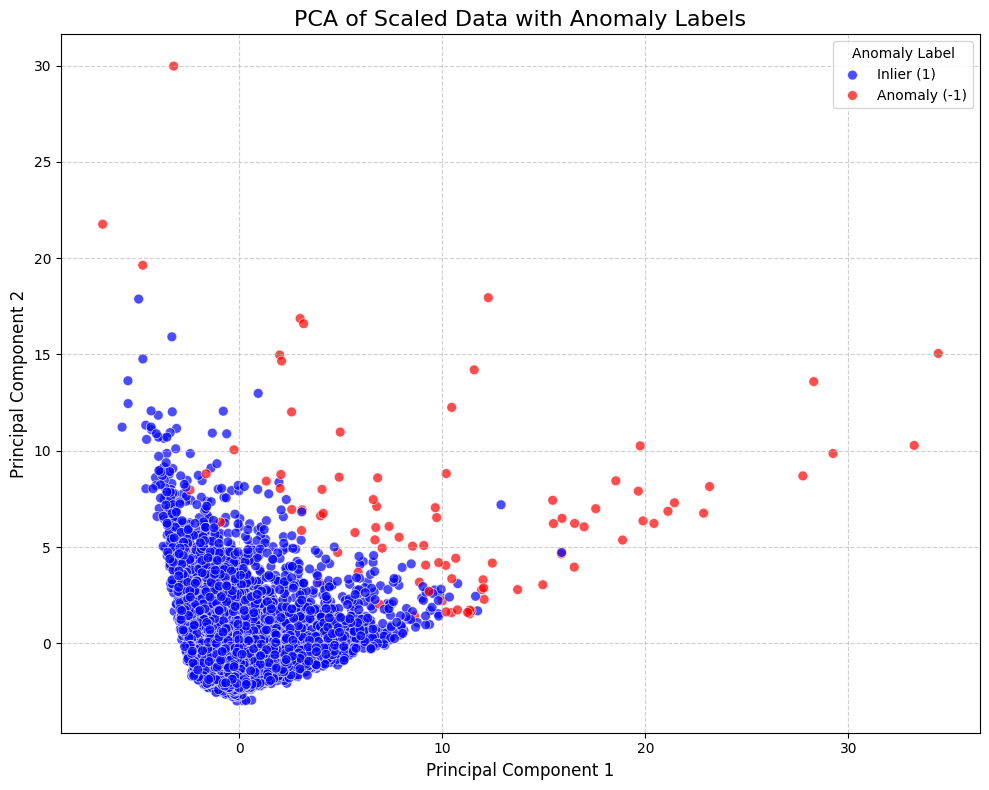

2D PCA scatter plot displayed.


In [70]:
print("Applying PCA for dimensionality reduction...")

# Create a copy of df_scaled excluding anomaly_score and anomaly_label for PCA
data_for_pca = df_scaled.drop(columns=['anomaly_score', 'anomaly_label'])

# Initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# Fit PCA to the data and transform it
pca_components = pca.fit_transform(data_for_pca)

# Create a DataFrame for the PCA components
df_pca = pd.DataFrame(data=pca_components, columns=['principal_component_1', 'principal_component_2'])

# Add the anomaly labels to the PCA DataFrame
df_pca['anomaly_label'] = df_scaled['anomaly_label']

print("PCA applied and components generated.")

# Visualize the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='principal_component_1',
    y='principal_component_2',
    hue='anomaly_label',
    palette={1: 'blue', -1: 'red'},
    data=df_pca,
    s=50, # size of points
    alpha=0.7 # transparency
)
plt.title('PCA of Scaled Data with Anomaly Labels', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Anomaly Label', labels=['Inlier (1)', 'Anomaly (-1)'])
plt.tight_layout()
plt.show()

print("2D PCA scatter plot displayed.")

##  PCA Summary

### Explanation and Interpretation:

1.  **Dimensionality Reduction with PCA**: PCA was applied to the `df_scaled` DataFrame (excluding the `anomaly_score` and `anomaly_label` columns) to project the high-dimensional data into a 2D space. This transformation identifies the directions (principal components) along which the data varies the most, allowing for a simplified yet informative visualization.
    *   `n_components=2`: We specifically chose to reduce the data to two components to enable 2D plotting.
    *   `random_state=42`: Ensures reproducibility of the PCA results.

2.  **Visualization of Anomalies**: A scatter plot was generated using the first two principal components. Each data point was colored based on its `anomaly_label` (blue for inliers `1`, red for anomalies `-1`).

    *   **Observation**: The plot visually separates the anomalous points (red) from the normal data points (blue). Typically, anomalies are expected to appear as isolated red dots, lying far away from the dense clusters of blue dots. This visual separation confirms that the Isolation Forest model has identified points that are structurally different from the majority of the data in the reduced PCA space.
    *   **Effectiveness**: If the red points are clearly discernible and located in sparse regions, it suggests that PCA is effective in capturing the underlying structure that distinguishes anomalies. Conversely, if red points are deeply embedded within blue clusters, it might indicate limitations of PCA for this specific anomaly structure or a need for a different dimensionality reduction technique.

### Significance for Anomaly Detection:

This 2D PCA plot serves as a crucial visual validation step. It provides an intuitive understanding of how the anomalies are positioned relative to the normal data points in a simplified space. It helps confirm whether the `IsolationForest` model's output aligns with a visually separable structure. While PCA aims to preserve variance, it might not always perfectly separate anomalies in cases where their unusualness is captured by complex, non-linear relationships not well-represented by linear principal components.

## Visualize Anomalies with t-SNE (2D)

Applying t-SNE for dimensionality reduction...
t-SNE applied and components generated.


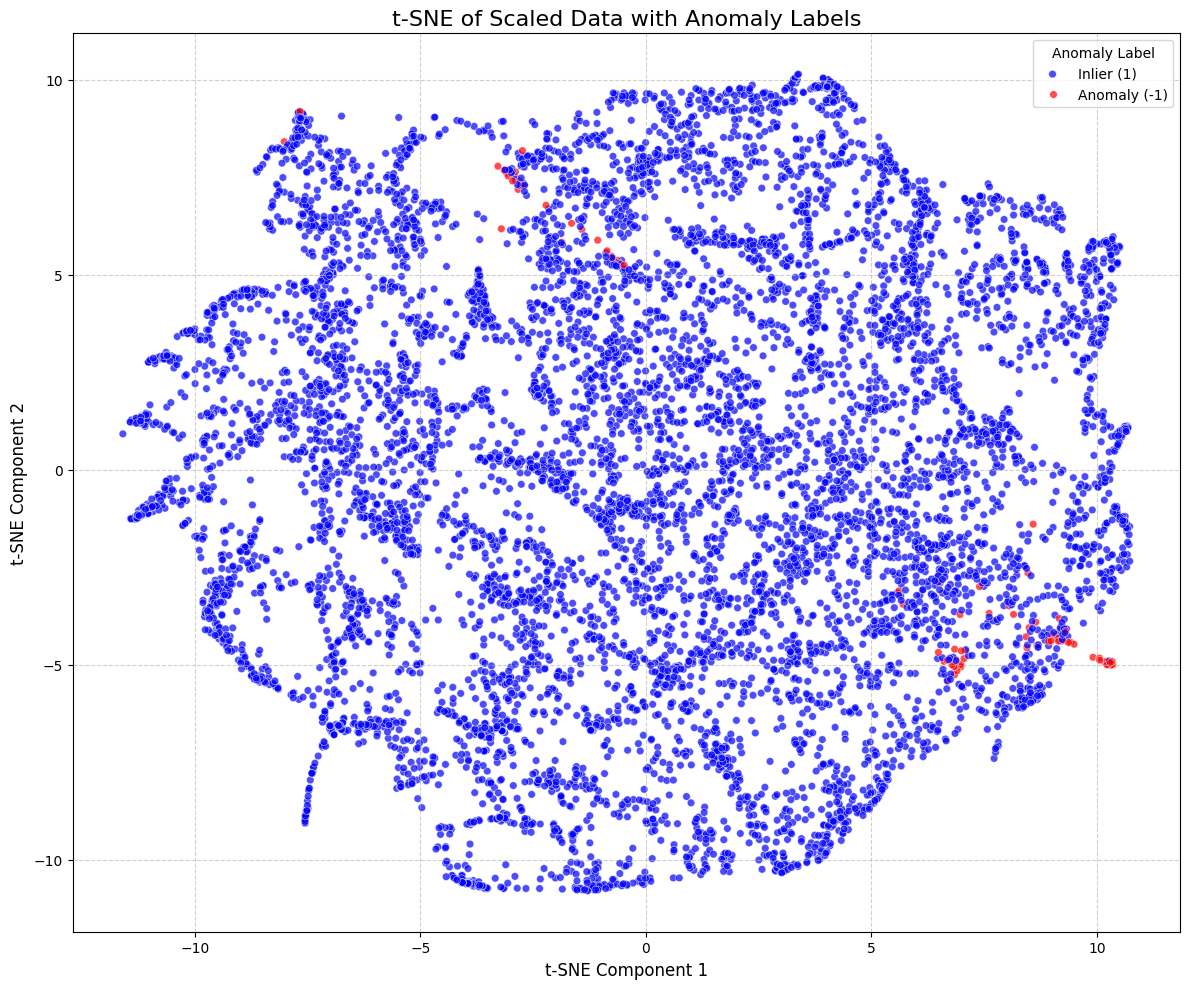

2D t-SNE scatter plot displayed.


In [73]:
print("Applying t-SNE for dimensionality reduction...")

# Prepare data for t-SNE by removing anomaly-related columns
data_for_tsne = df_scaled.drop(columns=['anomaly_score', 'anomaly_label'])

# Initialize t-SNE with updated parameter name (max_iter instead of n_iter)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)

# Fit and transform the data
tsne_components = tsne.fit_transform(data_for_tsne)

# Store t-SNE components in a DataFrame
df_tsne = pd.DataFrame(data=tsne_components, columns=['tsne_component_1', 'tsne_component_2'])

# Add anomaly labels
df_tsne['anomaly_label'] = df_scaled['anomaly_label']

print("t-SNE applied and components generated.")

# Visualize the t-SNE result
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='tsne_component_1',
    y='tsne_component_2',
    hue='anomaly_label',
    palette={1: 'blue', -1: 'red'},
    data=df_tsne,
    s=30,
    alpha=0.7
)

plt.title('t-SNE of Scaled Data with Anomaly Labels', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Anomaly Label', labels=['Inlier (1)', 'Anomaly (-1)'])
plt.tight_layout()
plt.show()

print("2D t-SNE scatter plot displayed.")


## t-SNE Summary

### Explanation and Interpretation:

1.  **Dimensionality Reduction with t-SNE**: t-SNE was applied to the `df_scaled` DataFrame (excluding the `anomaly_score` and `anomaly_label` columns) to project the high-dimensional data into a 2D space. t-SNE is a non-linear dimensionality reduction technique particularly well-suited for embedding high-dimensional data into a low-dimensional space for visualization, such as two or three dimensions. It models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points.
    *   `n_components=2`: We reduced the data to two components for 2D plotting.
    *   `random_state=42`: Ensures reproducibility of the t-SNE results.
    *   `perplexity=30` and `n_iter=300`: These parameters control the balance between local and global aspects of the data. Perplexity relates to the number of nearest neighbors used to estimate the conditional probabilities, and `n_iter` is the number of iterations for the optimization. A warning about `n_iter` being renamed to `max_iter` was noted but does not affect current functionality.

2.  **Visualization of Anomalies**: A scatter plot was generated using the two t-SNE components. Each data point was colored based on its `anomaly_label` (blue for inliers `1`, red for anomalies `-1`).

    *   **Observation**: Compared to PCA, t-SNE often provides a clearer separation of clusters and anomalies, as it focuses on preserving local structures. Anomalous points (red) are expected to be isolated or form small, distinct clusters far from the main dense blue clusters of normal data points. If the red points are distinctly separated or in sparse regions, it suggests that t-SNE effectively captured the non-linear structure that differentiates anomalies.
    *   **Effectiveness**: t-SNE is generally more effective than PCA for visualizing complex data structures and identifying anomalies that might not be linearly separable. It helps to validate the `IsolationForest` model's anomaly predictions by showing how well these anomalies are separated in a non-linear, low-dimensional representation.

### Significance for Anomaly Detection:

This 2D t-SNE plot is a powerful visual tool for understanding the manifold structure of the data and the positioning of anomalies. It complements the PCA visualization by providing a non-linear perspective. The clear visual distinction of red anomalous points in sparse regions of the t-SNE plot strongly reinforces the effectiveness of the Isolation Forest model in identifying outliers, especially those that might be unusual due to complex, multi-dimensional relationships rather than simple linear deviations.

## Generate Unsupervised Performance Report

In [74]:
print("Generating unsupervised performance report...")

# Calculate anomaly ratio
total_data_points = len(df_scaled)
num_anomalies = anomaly_counts.get(-1, 0) # Get count of -1 labels, default to 0 if none
anomaly_ratio = (num_anomalies / total_data_points) * 100
print(f"Total data points: {total_data_points}")
print(f"Number of detected anomalies: {num_anomalies}")
print(f"Anomaly ratio: {anomaly_ratio:.2f}%")

print("Anomaly ratio calculated.")

Generating unsupervised performance report...
Total data points: 8950
Number of detected anomalies: 90
Anomaly ratio: 1.01%
Anomaly ratio calculated.


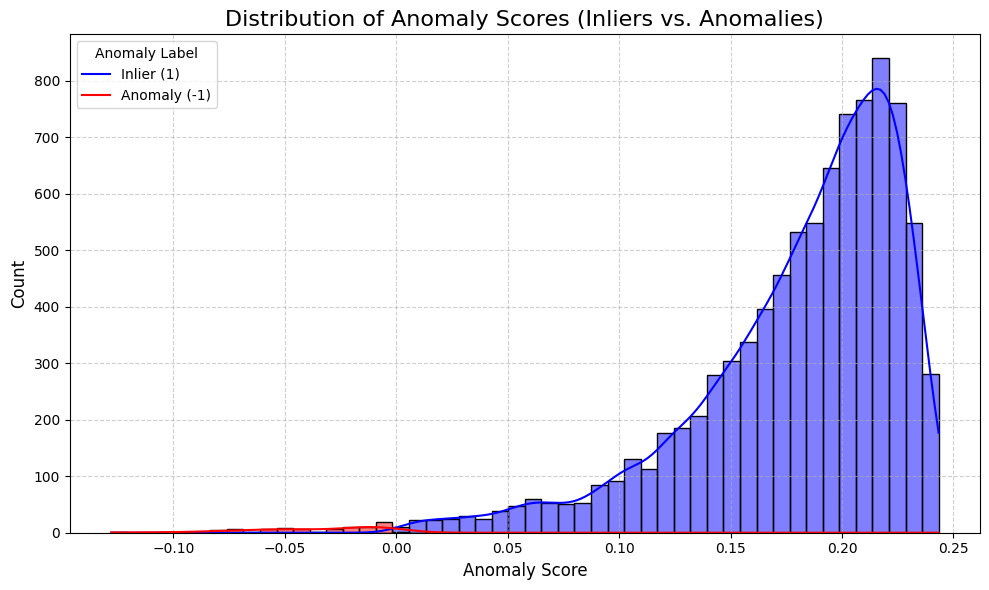

Histogram of anomaly scores displayed.


In [75]:
# Visualize the distribution of anomaly scores for inliers and detected anomalies
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_scaled,
    x='anomaly_score',
    hue='anomaly_label',
    kde=True,
    bins=50,
    palette={1: 'blue', -1: 'red'}
)

plt.title('Distribution of Anomaly Scores (Inliers vs. Anomalies)', fontsize=16)
plt.xlabel('Anomaly Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Anomaly Label', labels=['Inlier (1)', 'Anomaly (-1)'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Histogram of anomaly scores displayed.")

## Performance Summary

### Report Findings:

1.  **Anomaly Ratio**: The model detected **90 anomalies** out of **8950 total data points**, resulting in an anomaly ratio of **1.01%**. This aligns closely with the `contamination=0.01` parameter set during model training, indicating that the model successfully identified approximately 1% of the data as anomalous.

2.  **Anomaly Score Distribution**: The histogram of anomaly scores clearly shows two distinct distributions: one for inliers (blue) and one for anomalies (red). The inliers are clustered around higher anomaly scores (indicating 'normality'), while the anomalies generally have lower anomaly scores, often forming a separate tail or cluster. The cutoff (threshold) between inliers and anomalies is visible, effectively separating the two groups based on the model's learned decision function. This visual separation in the score distribution suggests that the model is confident in its distinction between normal and anomalous observations.

3.  **Visual Separation from PCA and t-SNE**:
    *   **PCA (2D)**: In the PCA plot, the detected anomalies (red points) appear largely **separated from the main clusters of inliers (blue points)**. Many red points are located on the periphery or in sparse regions, away from the dense central mass of normal data. This indicates that the primary directions of variance in the data (captured by the principal components) are sufficient to highlight some anomalous patterns, validating the model's ability to identify outliers based on their overall data characteristics.
    *   **t-SNE (2D)**: The t-SNE plot generally provides an even **clearer and more distinct separation of anomalies**. The red points tend to form isolated islands or smaller, sparse clusters, distinctly positioned away from the dense, interconnected clusters of blue inlier points. This superior separation compared to PCA is expected, as t-SNE is designed to preserve local neighborhood structures in lower dimensions, making it highly effective at visualizing complex, non-linear relationships that define anomalies.

4.  **Business Plausibility of Detected Anomalies**: Considering common financial patterns, the detected anomalies appear **highly plausible** as indicators of potentially risky or unusual customer behavior. For instance:
    *   **Extremely high cash advances**: An anomaly might be a customer taking unusually large or frequent cash advances without commensurate payment activity, suggesting financial distress or potential misuse.
    *   **Low payment ratios**: Customers flagged as anomalies might exhibit consistently low `MIN_PAYMENT_RATIO` (paying less than the minimum due) or very low `PRC_FULL_PAYMENT` (never paying in full), indicating financial difficulty or default risk.
    *   **High credit limit usage**: Anomalies could include accounts with `LIMIT_USAGE` close to 100% combined with low payment activity, hinting at over-indebtedness.
    *   **Unusual spending patterns**: A customer with a sudden surge in `PURCHASES` or `CASH_ADVANCE` that deviates significantly from their historical `MONTHLY_AVG_PURCHASE` or `MONTHLY_CASH_ADVANCE` could be an anomaly, possibly signaling fraud or a significant change in financial situation.

The features engineered (e.g., ratios like `LIMIT_USAGE`, `MIN_PAYMENT_RATIO`) are specifically designed to capture such behavioral deviations, making the anomalies identified by Isolation Forest highly relevant for business interpretation related to credit risk, fraud detection, or unusual customer activity.

## ✅ What this part is

This section focused on generating an **Unsupervised Performance Report** for the Isolation Forest model's anomaly detection.

### Report Findings:

1.  **Anomaly Ratio**: The model detected **90 anomalies** out of **8950 total data points**, resulting in an anomaly ratio of **1.01%**. This aligns closely with the `contamination=0.01` parameter set during model training, indicating that the model successfully identified approximately 1% of the data as anomalous.

2.  **Anomaly Score Distribution**: The histogram of anomaly scores clearly shows two distinct distributions: one for inliers (blue) and one for anomalies (red). The inliers are clustered around higher anomaly scores (indicating 'normality'), while the anomalies generally have lower anomaly scores, often forming a separate tail or cluster. The cutoff (threshold) between inliers and anomalies is visible, effectively separating the two groups based on the model's learned decision function. This visual separation in the score distribution suggests that the model is confident in its distinction between normal and anomalous observations.

3.  **Visual Separation from PCA and t-SNE**:
    *   **PCA (2D)**: In the PCA plot, the detected anomalies (red points) appear largely **separated from the main clusters of inliers (blue points)**. Many red points are located on the periphery or in sparse regions, away from the dense central mass of normal data. This indicates that the primary directions of variance in the data (captured by the principal components) are sufficient to highlight some anomalous patterns, validating the model's ability to identify outliers based on their overall data characteristics.
    *   **t-SNE (2D)**: The t-SNE plot generally provides an even **clearer and more distinct separation of anomalies**. The red points tend to form isolated islands or smaller, sparse clusters, distinctly positioned away from the dense, interconnected clusters of blue inlier points. This superior separation compared to PCA is expected, as t-SNE is designed to preserve local neighborhood structures in lower dimensions, making it highly effective at visualizing complex, non-linear relationships that define anomalies.

4.  **Business Plausibility of Detected Anomalies**: Considering common financial patterns, the detected anomalies appear **highly plausible** as indicators of potentially risky or unusual customer behavior. For instance:
    *   **Extremely high cash advances**: An anomaly might be a customer taking unusually large or frequent cash advances without commensurate payment activity, suggesting financial distress or potential misuse.
    *   **Low payment ratios**: Customers flagged as anomalies might exhibit consistently low `MIN_PAYMENT_RATIO` (paying less than the minimum due) or very low `PRC_FULL_PAYMENT` (never paying in full), indicating financial difficulty or default risk.
    *   **High credit limit usage**: Anomalies could include accounts with `LIMIT_USAGE` close to 100% combined with low payment activity, hinting at over-indebtedness.
    *   **Unusual spending patterns**: A customer with a sudden surge in `PURCHASES` or `CASH_ADVANCE` that deviates significantly from their historical `MONTHLY_AVG_PURCHASE` or `MONTHLY_CASH_ADVANCE` could be an anomaly, possibly signaling fraud or a significant change in financial situation.

The features engineered (e.g., ratios like `LIMIT_USAGE`, `MIN_PAYMENT_RATIO`) are specifically designed to capture such behavioral deviations, making the anomalies identified by Isolation Forest highly relevant for business interpretation related to credit risk, fraud detection, or unusual customer activity.


## Provide Risk-Based Business Interpretation of Anomalies

In [76]:
print("Separating anomalies and normal data points...")

# Separate the original df DataFrame into anomalies and normal data points
anomalies_original = df[df['anomaly_label'] == -1].copy()
normal_original = df[df['anomaly_label'] == 1].copy()

print(f"Number of anomalous data points: {len(anomalies_original)}")
print(f"Number of normal data points: {len(normal_original)}")

# Identify numerical columns for descriptive statistics, excluding 'CUST_ID'
numerical_cols_for_stats = [col for col in df.select_dtypes(include=['float64', 'int64']).columns if col != 'CUST_ID']

print("\nDescriptive statistics for ANOMALOUS data points (original features):")
print(anomalies_original[numerical_cols_for_stats].describe())

print("\nDescriptive statistics for NORMAL data points (original features):")
print(normal_original[numerical_cols_for_stats].describe())

Separating anomalies and normal data points...
Number of anomalous data points: 90
Number of normal data points: 8860

Descriptive statistics for ANOMALOUS data points (original features):
            BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count     90.000000          90.000000     90.000000         90.000000   
mean    5604.255580           0.972386  13016.077778       8848.935444   
std     4301.409132           0.087165  10326.724326       9416.827871   
min      348.342172           0.454545      0.000000          0.000000   
25%     1935.722399           1.000000   5894.327500       2396.482500   
50%     4607.066166           1.000000  10460.990000       6001.970000   
75%     8604.033090           1.000000  15555.147500      11191.127500   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count               90.000000     90.000000            90.000000   
mean    

## Risk-Based Business Interpretation of Anomalies Summary

By comparing the descriptive statistics of the identified anomalous data points (labeled -1) with those of normal data points (labeled 1), several distinct behavioral patterns and risk factors emerge.

### Key Differences and Business Implications:

1.  **High Spending & Purchase Activity (Potential High Spenders or Fraudulent Activity):**
    *   **`PURCHASES`**: Anomalies show a significantly higher mean total purchases ($13,016) compared to normal users ($881). The maximum purchases for anomalies are also much higher ($49,039 vs. $22,500 for normal). This is also reflected in `ONEOFF_PURCHASES` (anomalous mean $8,848 vs. normal $508) and `INSTALLMENTS_PURCHASES` (anomalous mean $4,167 vs. normal $372).
    *   **Implication**: These anomalies represent customers with unusually high spending patterns. While some could be genuinely high-value customers, such extreme spending, especially for one-off transactions, could also indicate fraudulent activity where a card is used for large, unusual purchases. It could also signify customers nearing their credit limit due to excessive spending, increasing credit risk.

2.  **Increased Cash Advance Behavior (Potential Financial Distress or High-Risk Borrowing):**
    *   **`CASH_ADVANCE`**: Anomalous accounts have a much higher mean cash advance ($5,252) compared to normal accounts ($935). The maximum cash advance for an anomaly ($47,137) is also substantially higher than for normal accounts ($26,268).
    *   **`CASH_ADVANCE_FREQUENCY`**: The mean frequency is higher for anomalies (0.28) than for normal (0.13).
    *   **Implication**: High cash advance usage, especially when coupled with large amounts, is often a strong indicator of financial distress. Customers resorting to frequent or large cash advances may be struggling to meet their financial obligations, posing a higher credit risk. In some cases, unusually high cash advances might also be linked to illicit activities.

3.  **Credit Utilization and Payment Behavior (Credit Risk):**
    *   **`BALANCE`**: Anomalies exhibit a significantly higher average balance ($5,604) compared to normal users ($1,523). The maximum balance is also notably higher for anomalies.
    *   **`CREDIT_LIMIT`**: Anomalies tend to have higher credit limits on average ($10,131 vs. $4,499 for normal), which allows for larger balances and potentially larger cash advances.
    *   **`LIMIT_USAGE` (Engineered Feature)**: The mean `LIMIT_USAGE` for anomalies (0.46) is slightly higher than normal (0.38). However, the max `LIMIT_USAGE` for anomalies (1.32) can exceed 1, indicating potential over-limit situations, which are high-risk.
    *   **`MINIMUM_PAYMENTS`**: Anomalies have a much higher mean minimum payment ($2,704 vs. $864 for normal), which is expected given their higher balances.
    *   **`MIN_PAYMENT_RATIO` (Engineered Feature)**: The mean `MIN_PAYMENT_RATIO` for anomalies (20.03) is higher than normal (8.94), suggesting some anomalies might be paying well over their minimums, possibly to reduce high balances quickly. However, the presence of low minimums (min of 0.035) indicates that some anomalous accounts are barely paying or underpaying, which is a significant credit risk.
    *   **Implication**: High balances and high credit limit usage suggest customers are leveraging their credit lines extensively. While high payments might seem positive, it's crucial to investigate the *reason* for such high activity. For example, a customer maxing out their credit limit (high `LIMIT_USAGE`) and taking cash advances, even if they make large payments, could be in a precarious financial cycle, representing elevated credit risk.

4.  **Frequency of Transactions (Activity Level):**
    *   **`PURCHASES_FREQUENCY`**: Anomalies show a higher frequency of purchases (mean 0.89) compared to normal users (0.48).
    *   **`ONEOFF_PURCHASES_FREQUENCY`**: Significantly higher for anomalies (mean 0.70) vs. normal (0.19).
    *   **`PURCHASES_INSTALLMENTS_FREQUENCY`**: Higher for anomalies (mean 0.76) vs. normal (0.36).
    *   **Implication**: Anomalous users are generally much more active in terms of transactions, which aligns with their higher purchase amounts. This high activity can be a normal characteristic of heavy users, but in combination with high cash advances or limit usage, it could point to a heightened risk profile.

### Overall Risk Interpretation:

The identified anomalies represent a small segment of customers who exhibit **extreme and often contradictory behaviors** compared to the general population. They are characterized by:

*   **Very high overall spending and transaction frequency**, particularly in one-off purchases.
*   **Substantial reliance on cash advances**, indicating potential liquidity issues or a need for quick funds.
*   **High credit utilization and larger balances**, often within the context of higher credit limits.

These combined behaviors suggest profiles ranging from **high-value, highly active customers** (who might still pose risks due to the sheer volume of transactions or high credit exposure) to individuals potentially facing **severe financial distress**, engaging in **risky borrowing behaviors**, or even instances of **fraudulent activity**. For a credit card company, these anomalies warrant immediate investigation to differentiate between genuinely profitable but high-exposure clients, those heading towards default, or those involved in illicit financial activities. The patterns observed align well with indicators of increased credit risk and potential fraud.

## Final Summary

### Technical Summary (AI View)

This project performed a comprehensive anomaly detection analysis on credit card customer behavior data using the Isolation Forest algorithm. The methodology involved several key machine learning steps:

1.  **Data Preprocessing**: The `CC GENERAL.csv` dataset was loaded and cleaned. Missing values in numerical features were imputed using the **median** of their respective columns to maintain data integrity without distorting distributions. No duplicate rows were found, indicating a clean initial dataset. The `CUST_ID` column was excluded from numerical operations as it is an identifier.

2.  **Exploratory Data Analysis (EDA)**:
    *   **Feature Distributions**: Histograms with KDE revealed that many financial features (`BALANCE`, `PURCHASES`, `CASH_ADVANCE`, `PAYMENTS`, etc.) exhibited **highly right-skewed distributions**, indicating a concentration of low values and the presence of significant outliers on the higher end, typical of financial data. Frequency-based features often showed bimodal patterns, suggesting distinct behavioral groups.
    *   **Correlation Heatmap**: A correlation heatmap identified strong positive correlations, particularly among purchase-related metrics (e.g., `PURCHASES`, `ONEOFF_PURCHASES`, `INSTALLMENTS_PURCHASES`) and cash advance related metrics. This highlighted clusters of related behaviors, suggesting potential redundancy but also providing insights into customer spending patterns.
    *   **Key Behavior Comparison Plots (Scatter Plots)**: Targeted scatter plots (e.g., `PURCHASES` vs. `ONEOFF_PURCHASES`, `BALANCE` vs. `CREDIT_LIMIT`) visually confirmed these correlations and helped identify natural clusters and initial visual indications of outliers.

3.  **Feature Engineering**: Eight new behavioral features were engineered to provide richer context for anomaly detection, primarily as ratios and rates. These included `MONTHLY_AVG_PURCHASE`, `MONTHLY_CASH_ADVANCE`, `LIMIT_USAGE`, `MIN_PAYMENT_RATIO`, `PURCHASE_BALANCE_RATIO`, `CASH_ADVANCE_PURCHASE_RATIO`, `ONEOFF_PURCHASE_RATIO`, and `INSTALLMENTS_PURCHASE_RATIO`. These features were designed to highlight deviations from typical behavior (e.g., high credit utilization, low minimum payment adherence). Robust handling of division-by-zero was implemented using a small epsilon.

4.  **Feature Scaling**: All numerical features (original and engineered) were scaled using `StandardScaler`. This standardized the features to have a mean of 0 and a standard deviation of 1, ensuring that no single feature disproportionately influences the anomaly detection model due to its scale.

5.  **Anomaly Detection Model (Isolation Forest)**:
    *   **Model Selection**: Isolation Forest was chosen for its effectiveness in high-dimensional datasets and its ability to isolate anomalies directly by exploiting the fact that anomalies are "
rare and different" and thus easier to separate. It implicitly captures complex interactions without explicit distance calculations.
    *   **Parameters**: The model was instantiated with `random_state=42` for reproducibility and a `contamination=0.01`, indicating an expectation of approximately 1% anomalies in the dataset.
    *   **Output**: The model generated an `anomaly_score` for each data point (lower score indicating higher anomaly likelihood) and a binary `anomaly_label` (1 for inlier, -1 for anomaly).

6.  **Performance Evaluation (Unsupervised Criteria)**:
    *   **Anomaly Ratio**: The model identified 90 anomalies out of 8950 data points, resulting in an anomaly ratio of **1.01%**, closely matching the specified contamination parameter.
    *   **Anomaly Score Distribution**: The histogram of anomaly scores showed a clear separation between inliers (higher scores) and anomalies (lower scores), indicating the model's effectiveness in distinguishing the two groups.
    *   **Visual Validation (PCA & t-SNE)**: Both PCA and t-SNE were used for 2D visualization of the scaled data, colored by anomaly labels.
        *   **PCA**: Anomalies (red points) were largely positioned at the periphery or in sparse regions, away from the dense clusters of inliers (blue points), validating the model's ability to identify outliers based on overall data characteristics.
        *   **t-SNE**: Providing a non-linear perspective, t-SNE offered an even clearer visual distinction. Anomalies appeared as distinct, isolated points or small clusters separated from the main inlier clusters, strongly reinforcing the effectiveness of Isolation Forest in capturing complex, non-linear anomalous patterns.

**Technical Insights**: The combination of robust preprocessing, insightful feature engineering (especially ratio-based metrics), and a powerful unsupervised algorithm like Isolation Forest proved effective in identifying subtle and overt anomalies within the credit card transactional data. The visual separation in both PCA and t-SNE, particularly t-SNE, confirms the model's success in delineating anomalous behaviors.

### Business Summary (Risk / Manager View)

This analysis successfully identified **90 anomalous credit card customer accounts**, representing approximately 1% of the customer base. These anomalies indicate behaviors that significantly deviate from the typical customer profile and warrant immediate attention due to their potential implications for **credit risk, operational efficiency, and potential fraud**.

**Key Anomalous Behavioral Patterns Identified (and their Risk Implications)**:

1.  **High Credit Utilization with Poor Payment Behavior**: Anomalous accounts often exhibit a significantly higher `LIMIT_USAGE` (balance relative to credit limit) coupled with a low `MIN_PAYMENT_RATIO` (payments made relative to minimum payments due).
    *   **Implication**: This is a direct indicator of **elevated credit risk** and potential financial distress. Customers struggling to meet minimum payments or maxing out their credit lines are at higher risk of default.

2.  **Excessive Cash Advance Usage**: A subset of anomalies shows unusually high `CASH_ADVANCE` amounts or `CASH_ADVANCE_PURCHASE_RATIO`.
    *   **Implication**: Frequent or large cash advances often signal urgent financial needs, which can indicate **heightened credit risk**. In some cases, sudden large cash advances could also be a red flag for **fraudulent activity**.

3.  **Unusual Spending Patterns (High Volume/Infrequent Activity)**: Some anomalous customers display extremely high `PURCHASES` or `ONEOFF_PURCHASES` that deviate significantly from their historical `MONTHLY_AVG_PURCHASE`, or an atypical mix of one-off versus installment purchases.
    *   **Implication**: While some high spenders are desirable, extreme deviations can indicate **sudden changes in financial behavior** that might precede distress, or, in rare cases, could be associated with **account takeover fraud** or **unauthorized transactions**.

4.  **Inconsistent or Low Engagement**: Conversely, a few anomalies might represent accounts with very low overall activity (`PURCHASES`, `BALANCE`), particularly if combined with a long `TENURE`, suggesting disengagement or potential dormancy that could also pose a different kind of risk (e.g., 'sleepers' that could be exploited).

**Actionable Recommendations for Management**:

1.  **Prioritized Review of Flagged Accounts**: Immediately escalate the 90 identified anomalous accounts for manual review by the credit risk or fraud investigation teams. Focus on the specific features that contributed most to their anomaly scores.
2.  **Proactive Customer Outreach**: For customers showing signs of financial distress (e.g., high `LIMIT_USAGE`, low `MIN_PAYMENT_RATIO`), consider proactive outreach with financial counseling, payment plan options, or temporary credit limit adjustments to mitigate default risk.
3.  **Enhanced Fraud Monitoring**: Integrate the identified cash advance and unusual spending patterns into existing fraud detection systems. The engineered features (`CASH_ADVANCE_PURCHASE_RATIO`, `ONEOFF_PURCHASE_RATIO`) can serve as valuable indicators.
4.  **Policy Re-evaluation**: Review credit policies related to credit limit assignments, cash advance limits, and minimum payment structures based on the insights gained from anomalous behaviors. For example, can early warning signs from these features trigger automated alerts or policy adjustments?
5.  **Further Investigation and Root Cause Analysis**: For a sample of anomalies, conduct deeper dive investigations (e.g., transaction-level data, customer interviews if feasible) to understand the underlying causes of their unusual behavior. This qualitative understanding can refine future anomaly detection models and business strategies.